# Temporal Order Classification Experiments Companion Notebook
##### Sean-Jiun Wang - August 2, 2018

---

The second Computational and Data Science for High Energy Physics ([CODAS-HEP](http://codas-hep.org)) school was a welcome respite from my physics analysis. It was a tremendous opportunity to learn more about topics close to my heart, engage in fantastic conversations, and even reconnect with friends.

During the school, Alfredo Canziani of New York University's Center for Data Science and Alexey Svyatkovskiy of Princeton University presented a series of machine learning lectures and demos. On the last day, their survey of deep learning concluded with an overview of recurrent neural networks (RNNs) and their applications towards problems dealing with sequence data. Their final [demo](https://github.com/Atcold/pytorch-Deep-Learning-Minicourse/blob/master/08-3-temporal_order_classification_experiments.ipynb) trained a simple RNN for sequence classification up to 96% accuracy. At the end of their session, they asked those interested to try and see if better performance could be achieved. I ended up with plenty of free time to do so after my flight home was cancelled by the weather and I found myself rebooked with a three-leg journey...

After rerunning the demo many times, I have concluded that it is actually an "exercise left to the reader" in disguise. For instance, merely increasing the batch size of sequences from 32 to 64 increases the accuracy to a bizarre 192%! In the rest of this notebook, I'll walk through my version of the demo. I've tried my best to include extensive comments so that, whenever you spot pieces of code that are different from the original demo, you can understand the motivation behind my modifications. Obligatory spoiler warning for those trying to figure out the original demo. Ready? Let's get started!

## 1. What's the data?

Let's review the data we're working with, as it will help with understanding how different pieces should fit together later on. The sequence classification task is described in the docstring of the class used to generate data and comes from the original paper introducing long short-term memory (LSTM) networks.

In [1]:
from sequential_tasks import TemporalOrderExp6aSequence
%pdoc TemporalOrderExp6aSequence

Class docstring:
    From Hochreiter&Schmidhuber(1997):
    
        The goal is to classify sequences. Elements and targets are represented locally
        (input vectors with only one non-zero bit). The sequence starts with an E, ends
        with a B (the "trigger symbol") and otherwise consists of randomly chosen symbols
        from the set {a, b, c, d} except for two elements at positions t1 and t2 that are
        either X or Y . The sequence length is randomly chosen between 100 and 110, t1 is
        randomly chosen between 10 and 20, and t2 is randomly chosen between 50 and 60.
        There are 4 sequence classes Q, R, S, U which depend on the temporal order of X and Y.
        The rules are:
            X, X -> Q,
            X, Y -> R,
            Y , X -> S,
            Y , Y -> U.
Init docstring:
    Initialize self.  See help(type(self)) for accurate signature.

The problem statement described in the docstring corresponds to the `HARD` difficulty level of the sequence data generator. For now, let's stick with the original demo notebook's default difficulty setting of `EASY`, which poses the same classification task but with much shorter sequences:

* The sequence length is randomly set to 7 or 8.
* The first position $t_{1}$ is randomly set to 1 or 2.
* The second position $t_{2}$ is randomly set to 4 or 5.

I figured this out by peeking at the source code of the `sequential_tasks` module, but we should also generate some data to get a better feel for the inputs to our classifier.

In [2]:
# Create a data generator.
example_generator = TemporalOrderExp6aSequence.get_predefined_generator(
    # The first argument is the difficulty level of the classification task.
    difficulty_level=TemporalOrderExp6aSequence.DifficultyLevel.EASY,
    # The second argument is the number of sequences generated in each batch of data.
    # For efficiency, RNN's are typically trained over batches of sequences.
    batch_size=32,
)

example_batch = example_generator[0]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of class labels is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8).
The first element in the batch of sequences is:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4).
The first element in the batch of class labels is:
 [1. 0. 0. 0.]


When a batch of data is requested, the data generator returns a tuple whose first item is the batch of sequences and the second item is the batch of corresponding class labels.

For those not acquainted with machine learning, you may have expected to see letters rather than arrays of zeros and ones in the batch of sequences. While humans can learn from sequences of letters, that kind of representation of information isn't amenable to the vector and matrix operations underpinning machine learning algorithms. Therefore, before passing the sequences to the RNN as input, we *one-hot encode* the symbols in the sequence. As we have seen, the data generator class kindly takes care of this for us. The implementation of the one-hot encoding defines the following convention for our eight-symbol vocabulary:

| Symbol | One-Hot Encoding                 |
| :----: | :------------------------------: |
| X      | [1., 0., 0., 0., 0., 0., 0., 0.] |
| Y      | [0., 1., 0., 0., 0., 0., 0., 0.] |
| a      | [0., 0., 1., 0., 0., 0., 0., 0.] |
| b      | [0., 0., 0., 1., 0., 0., 0., 0.] |
| c      | [0., 0., 0., 0., 1., 0., 0., 0.] |
| d      | [0., 0., 0., 0., 0., 1., 0., 0.] |
| B      | [0., 0., 0., 0., 0., 0., 1., 0.] |
| E      | [0., 0., 0., 0., 0., 0., 0., 1.] |

The array shape for a batch of sequences is $(n_{sequences}, l_{sequence}^{max}, n_{features}) = (32, 9, 8)$. The first dimension is the number of sequences per batch, which has been manually set to 32. The second dimension is the length of the longest sequence, which is set by the data generator to 9. Although the sequence length is allowed to vary for our classification task, we are passing *batches* of sequences to the RNN and so the sequences must be padded with zeros up to a maximum length for consistency. There is no need to worry about why the length of the longest sequence was set to 9 instead of 8, and we'll go over why that detail is moot later when we design the training loop. The last dimension is the number of features, which for us is set by the number of symbols in our vocabulary.

Because this is a multiclass classification task and there are four classes, the class labels are one-hot encoded as well using the following convention:

| Class     | One-Hot Encoding |
| :-------: | :--------------: |
| X, X -> Q | [1., 0., 0., 0.] |
| X, Y -> R | [0., 1., 0., 0.] |
| Y, X -> S | [0., 0., 1., 0.] |
| Y, Y -> U | [0., 0., 0., 1.] |

The array shape for a batch of class labels is $(n_{sequences}, n_{classes}) = (32, 4)$.

Let's check our understanding by manually decoding the first sequence from the batch of sequences:

| One-Hot Encoded   | Decoded      |
| :---------------: | :----------: |
| [0 0 0 0 0 0 0 0] | zero padding |
| [0 0 0 0 0 0 1 0] | B            |
| [0 0 0 1 0 0 0 0] | b            |
| [1 0 0 0 0 0 0 0] | X            |
| [0 0 0 0 1 0 0 0] | c            |
| [1 0 0 0 0 0 0 0] | X            |
| [0 0 0 0 1 0 0 0] | c            |
| [0 0 0 1 0 0 0 0] | b            |
| [0 0 0 0 0 0 0 1] | E            |

The first sequence is "BbXcXcbE", ignoring the prepended zero that comes from padding the sequences. Since this sequence contains an X at both $t_{1}$ and $t_{2}$, the first sequence should have class label Q. And indeed, if we check the first class label from the batch of class labels, we see [1., 0., 0., 0.], which is the one-hot encoding for the class Q.

From now on, we'll use the decoding methods of the data generator to avoid reinventing things.

In [3]:
# Decoding the first sequence.
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence.
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is: {class_label_decoded}')

The sequence is: BbXcXcbE
The class label is: Q


## 2. Defining the RNN

We'll be using PyTorch as the deep learning framework of choice to define and train an RNN. The RNN is more or less copied from the original demo notebook but with some modifications and annotations. The things I point out are what I found useful to know, but feel free to peruse the [documentation](https://pytorch.org/docs/0.4.0/) for PyTorch for more information. They also have really good [tutorials](https://pytorch.org/tutorials/index.html).

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set the random seed for reproducible results.
torch.manual_seed(1)


class SimpleRNN(nn.Module):
    """A simple RNN module.
    
    In PyTorch, subclassing your model from torch.nn.Module
    takes care of low-level concerns for you such as defining
    the backward pass and keeping track of network parameters.
    
    Parameters
    ----------
    input_size : int
        The number of features in the input tensor.
    hidden_size : int
        The number of features in the hidden state of the RNN.
    output_size : int
        The number of classes in the output tensor.
    """
    def __init__(self, input_size, hidden_size, output_size):
        # This just calls the base class constructor.
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """The forward pass of the simple RNN.
        
        Subclasses of torch.nn.Module require the user to override
        the forward method to define their computation steps.
        
        Parameters
        ----------
        x : torch.Tensor
            The input tensor of shape (batch_size, max_sequence_length, input_size).

        Returns
        -------
        out : torch.Tensor
            The output tensor of shape (batch_size, max_sequence_length, output_size)
        """
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        x, _ = self.rnn(x)
        x = self.linear(x)
        out = F.log_softmax(x, dim=1)
        return out

## 3. Defining the Training Loop

The training loop contained the majority of the bugs, so I'll be sure to point things out in the code below so you can compare to how things were done in the original demo notebook. I've also modified the training loop to return the loss and number of correct examples after each batch which can be used to visually monitor the results of the training.

In [5]:
def train(model, train_data_gen, criterion, optimizer, device):
    """Train a model to classify sequences for the temporal ordering problem.
    
    Parameters
    ----------
    model : torch.nn.Module
        The model to train.
    train_data_gen : TemporalOrderExp6aSequence
        The data generator instance used to produce training data.
    criterion : torch.nn.Module
        The loss function.
    optimizer : torch.optim.Optimizer
        The optimization algorithm used to updated the network parameters.
    device : torch.device
        The device to which tensors will be moved.

    Returns
    -------
    tuple
        The number of correctly classified sequences and the loss, respectively.
    """
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()
    
    # Store the number of sequences that were classified correctly.
    num_correct = 0
    
    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for batch_idx in range(len(train_data_gen)):
        # For each new batch, clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()
        
        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        data, target = train_data_gen[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)
        
        # Perform the forward pass of the model.
        output = model(data)
        
        # Although the sequences are padded to a specific length, we noted earlier that they
        # actually have variable length. This point becomes relevant for interpreting the model's
        # output. We are interested in the output of the model AFTER it has seen an entire sequence,
        # which for our problem means just after the model encounters the stop token "E". But the
        # model produces an output at each step of a sequence, which is why the shape of the output
        # is (batch_size, max_sequence_length, output_size).
        #
        # We want to keep only those outputs which correspond to the end of a sequence. One approach
        # is to decode the sequences and then store the length of each sequence in a tensor. We can
        # then use this tensor for fancy indexing of the output, after subtracting 1 from it to
        # account for tensor indices starting from 0. The first dimension of the output needs to be
        # indexed using arange for the indexing to correctly pick out each batch. The final output
        # will be of shape (batch_size, output_size).
        data_decoded = train_data_gen.decode_x_batch(data.numpy())
        sequence_end = torch.tensor([len(sequence) for sequence in data_decoded]) - 1
        output = output[torch.arange(data.shape[0]).long(), sequence_end, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        target = target.argmax(dim=1)
        loss = criterion(output, target)
        
        # Backpropagation through time in two lines!
        loss.backward()
        optimizer.step()
        
        # One way to find the number of correctly classified sequences for each batch is to call
        # argmax along the second dimension of the output. This works because the output of the
        # RNN is the set of log probabilities for that sequence to belong to one of the classes,
        # so the result is a tensor of shape (batch_size) containing the class index with the
        # highest log probability for each sequence. We can then check for element-wise equality
        # between the predictions and the target and reduce the result to a scalar using sum.
        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

## 4. Defining the Testing Loop

Some of the problems encountered in the training loop are also present in the testing loop. For the sake of clarity, I'll just point out things that are different from the training loop since the testing loop reuses much of the same code.

In [6]:
def test(model, test_data_gen, criterion, device):
    """Test a model's classification performance for the temporal ordering problem.
    
    Parameters
    ----------
    model : torch.nn.Module
        The model to evaluate.
    test_data_gen : TemporalOrderExp6aSequence
        The data generator instance used to produce test data.
    criterion : torch.nn.Module
        The loss function.
    device : torch.device
        The device to which tensors will be moved.

    Returns
    -------
    tuple
        The number of correctly classified sequences and the loss, respectively.
    """
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()
    
    # Store the number of sequences that were classified correctly.
    num_correct = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)
            
            output = model(data)
            data_decoded = test_data_gen.decode_x_batch(data.numpy())
            sequence_end = torch.tensor([len(sequence) for sequence in data_decoded]) - 1
            output = output[torch.arange(data.shape[0]).long(), sequence_end, :]

            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

## 4. Putting it All Together

Now that we have defined the training and testing loops, our simple RNN is ready for training! I've combined them into a single function below to streamline the training and evaluation. And because I like to see plots, as most physicists do, the function will also plot the loss and accuracy of the model over the course of training.

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline


def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    """Train a model and monitor its performance.
    
    Parameters
    ----------
    model : torch.nn.Module
        The model to evaluate.
    train_data_gen : TemporalOrderExp6aSequence
        The data generator instance used to produce training data.
    test_data_gen : TemporalOrderExp6aSequence
        The data generator instance used to produce test data.
    criterion : torch.nn.Module
        The loss function.
    optimizer : torch.optim.Optimizer
        The optimization algorithm used to updated the network parameters.
    max_epochs : int
        The maximum number of times model iterates through all of the
        training data during training.
    verbose : bool, optional
        Report the loss and accuracy over the training and test sets for
        every epoch. The default is True.
    """
    # Automatically determine the device that PyTorch should use for computation.
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # Track the value of the loss function and model accuracy across epochs.
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}
    
    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)
        
        # Do the same for the testing loop.
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")
    
    # Generate diagnostic plots for the loss and accuracy.
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

Let's try it out using the same experimental settings used by the original demo notebook.

[Epoch 1/10] loss: 1.3729, acc: 27.22% - test_loss: 1.3747, test_acc: 31.65%
[Epoch 2/10] loss: 1.3874, acc: 31.85% - test_loss: 1.3728, test_acc: 31.15%
[Epoch 3/10] loss: 1.3548, acc: 33.87% - test_loss: 1.3570, test_acc: 35.28%
[Epoch 4/10] loss: 1.3511, acc: 35.18% - test_loss: 1.3359, test_acc: 35.18%
[Epoch 5/10] loss: 1.3241, acc: 35.48% - test_loss: 1.3780, test_acc: 35.89%
[Epoch 6/10] loss: 1.3549, acc: 39.31% - test_loss: 1.3100, test_acc: 39.72%
[Epoch 7/10] loss: 1.2783, acc: 38.41% - test_loss: 1.2807, test_acc: 41.13%
[Epoch 8/10] loss: 1.1884, acc: 42.84% - test_loss: 1.2319, test_acc: 49.09%
[Epoch 9/10] loss: 1.2123, acc: 53.43% - test_loss: 1.1182, test_acc: 56.75%
[Epoch 10/10] loss: 1.1269, acc: 59.58% - test_loss: 1.0940, test_acc: 58.57%


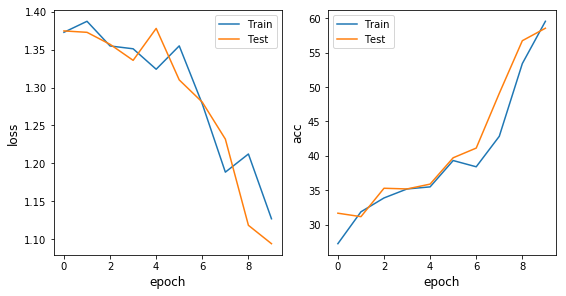

In [8]:
# Setup the training and test data generators.
difficulty     = TemporalOrderExp6aSequence.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)
test_data_gen  = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings.
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model.
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

Awesome, we see that our simple RNN is actually learning! There are a few encouraging signs that the demo is working correctly now:

* The accuracy of our model on the training set after the first epoch isn't too far from 25%. This intuitively fits the expectation that, because there are four classes, a model which randomly guesses or hasn't learned anything yet will have an accuracy of 25%.
* The training and test loss are both decreasing over time.
* The training and test accuracy are both increasing over time.

But is the accuracy actually calculated correctly? Remember that, in the original demo, increasing the batch size led to ludicrous values. Let's check by doubling the batch size to 64.

[Epoch 1/10] loss: 1.3749, acc: 29.58% - test_loss: 1.4008, test_acc: 29.79%
[Epoch 2/10] loss: 1.3729, acc: 32.19% - test_loss: 1.3584, test_acc: 29.17%
[Epoch 3/10] loss: 1.3827, acc: 28.44% - test_loss: 1.3615, test_acc: 29.69%
[Epoch 4/10] loss: 1.3731, acc: 31.25% - test_loss: 1.3570, test_acc: 30.63%
[Epoch 5/10] loss: 1.3808, acc: 31.15% - test_loss: 1.3615, test_acc: 31.56%
[Epoch 6/10] loss: 1.3865, acc: 31.15% - test_loss: 1.3475, test_acc: 34.06%
[Epoch 7/10] loss: 1.3701, acc: 31.46% - test_loss: 1.3314, test_acc: 33.12%
[Epoch 8/10] loss: 1.3556, acc: 34.17% - test_loss: 1.3423, test_acc: 34.27%
[Epoch 9/10] loss: 1.3344, acc: 34.90% - test_loss: 1.3322, test_acc: 33.23%
[Epoch 10/10] loss: 1.3257, acc: 33.54% - test_loss: 1.3574, test_acc: 36.25%


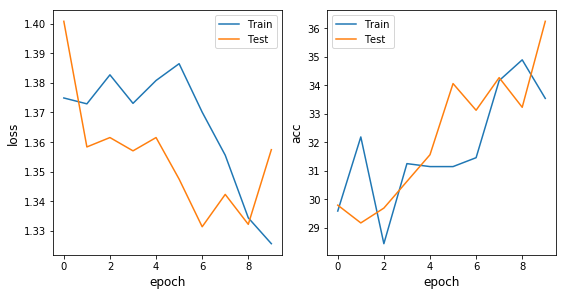

In [9]:
# Setup the training and test data generators.
difficulty     = TemporalOrderExp6aSequence.DifficultyLevel.EASY
batch_size     = 64
train_data_gen = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)
test_data_gen  = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings.
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model.
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

The accuracy didn't explode! But why did increasing the batch size decrease the accuracy? I think this comes from the implicit restriction on the total number of sequences. Because we train on a set number of sequences, doubling the batch size necessarily halves the total number of batches. So even though using a larger batch size produces better gradient estimates for updating the model parameters, there are half as many parameter updates happening as before. It also damps out the stochastic noise that comes with using smaller batch sizes, which offers a form of regularization.

## 5. Room for Improvement?

Our baseline model, defined and trained using the settings from the original demo, ends up with 58.57% test accuracy. But judging from the plots, one of the first things to try is to simply increase the number of epochs to get an idea of the model's learning capacity. Let's keep all of the settings from the baseline model and just increase the number of epochs to some ridiculous amount like 1000.

[Epoch 1000/1000] loss: 0.0000, acc: 100.00% - test_loss: 0.0000, test_acc: 100.00%


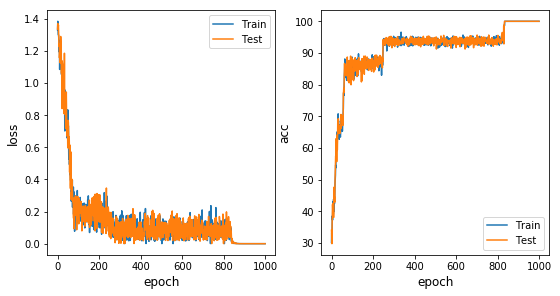

In [10]:
# Setup the training and test data generators.
difficulty     = TemporalOrderExp6aSequence.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)
test_data_gen  = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings.
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 1000

# Train the model.
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

It looks like the baseline model, once trained to convergence,  has the capacity to achieve perfect accuracy on the training and test sets. But we are not easily convinced, so we evaluate the model on a new batch of sequences. The next cell defines a function that will evaluate a model over a set of sequences and report back useful information such as the number of sequences generated for each class and actually print out some sequences for us to look at.

In [11]:
import collections
import random


def evaluate_model(model, difficulty, seed=9001, verbose=False):
    """Evaluate and report on the performance of the model.
    
    Parameters
    ----------
    model : torch.nn.Module
        The model to test.
    difficulty : int
        The difficulty level of the test sequences.
    seed : int, optional
        The random seed for the test sequence generator.
        The default is 9001.
    verbose : bool, optional
        Report every misclassified sequence. The default is False.
    """
    # Define a dictionary that maps class indices to labels.
    class_idx_to_label = {0: 'Q', 1: 'R', 2: 'S', 3: 'U'}

    # Create a new data generator.
    data_generator = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, seed=seed)

    # Track the number of times a class appears.
    count_classes = collections.Counter()

    # Keep correctly classified and misclassified sequences, and their
    # true and predicted class labels, for diagnostic information.
    correct = []
    incorrect = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.eval()

    with torch.no_grad():
        for batch_idx in range(len(data_generator)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            data_decoded = data_generator.decode_x_batch(data.numpy())
            target_decoded = data_generator.decode_y_batch(target.numpy())

            output = model(data)
            sequence_end = torch.tensor([len(sequence) for sequence in data_decoded]) - 1
            output = output[torch.arange(data.shape[0]).long(), sequence_end, :]

            target = target.argmax(dim=1)
            y_pred = output.argmax(dim=1)
            y_pred_decoded = [class_idx_to_label[y.item()] for y in y_pred]

            count_classes.update(target_decoded)
            for i, (truth, prediction) in enumerate(zip(target_decoded, y_pred_decoded)):
                if truth == prediction:
                    correct.append((data_decoded[i], truth, prediction))
                else:
                    incorrect.append((data_decoded[i], truth, prediction))
    
    num_sequences = sum(count_classes.values())
    accuracy = float(len(correct)) / num_sequences * 100 
    print(f'The accuracy of the model is measured to be {accuracy:.2f}%.\n')

    # Report the accuracy by class.
    for label in sorted(count_classes):
        num_correct = sum(1 for _, truth, _ in correct if truth == label)
        print(f'{label}: {num_correct} / {count_classes[label]} correct')
    
    # Report some random sequences for examination.
    print('\nHere are some example sequences:')
    for i in range(10):
        sequence, truth, prediction = correct[random.randrange(0, 10)] 
        print(f'{sequence} -> {truth} was labelled {prediction}')

    # Report misclassified sequences for investigation.
    if incorrect and verbose:
        print('\nThe following sequences were misclassified:')
        for sequence, truth, prediction in incorrect:
            print(f'{sequence} -> {truth} was labelled {prediction}')
    else:
        print('\nThere were no misclassified sequences.')

And how does the model do?

In [12]:
evaluate_model(model, difficulty)

The accuracy of the model is measured to be 100.00%.

Q: 258 / 258 correct
R: 249 / 249 correct
S: 232 / 232 correct
U: 253 / 253 correct

Here are some example sequences:
BbXcXbcE -> Q was labelled Q
BdYdXbbE -> S was labelled S
BbXcXbcE -> Q was labelled Q
BcYdYdaE -> U was labelled U
BcYacYbE -> U was labelled U
BYdcaYbE -> U was labelled U
BYdcaYbE -> U was labelled U
BYbdYabE -> U was labelled U
BdYdXbbE -> S was labelled S
BYbdYabE -> U was labelled U

There were no misclassified sequences.


I think we can concede that the simple model has solved the classification problem. Feel free to rerun the cell above to check different random samples of example sequences.

## 6. Where to go from here?

Solving a simplified version of a toy problem from a seminal deep learning paper is a good first step for debugging our code and understanding. From here, you can test your intuitions by turning up the difficulty level. Maybe you'll have to fiddle with the hyperparameters? Switch to an LSTM altogether? But this will only entertain you for so long while the problems that affect our lives and engage our curiosity are waiting for us to solve them. And those I leave as exercises to the reader.